In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *

In [2]:
data = pd.read_excel('../../base_futebol_3.xlsx')

In [35]:
def prepara_dataset(_df):
    # Limpa _df
    _df = _df[(_df['Avg_CG_H'] != 0) & (_df['Avg_CG_A'] != 0) & (_df['DP_CG_H'] != 0) & (_df['DP_CG_A'] != 0) & (_df['Avg_Pontos_H'] != 0) & (_df['Avg_Pontos_A'] != 0) & (_df['MediaCustoGolHome'] != 0) & (_df['MediaCustoGolAway'] != 0)]

    # Cria variáveis de retorno
    _df.reset_index(drop=True, inplace=True)

    _df.loc[(_df['FT_Odds_H'] > _df['FT_Odds_A']), 'Zebra'] = 'Home'
    _df.loc[(_df['FT_Odds_H'] < _df['FT_Odds_A']), 'Zebra'] = 'Away'
    _df.loc[(_df['Zebra'] == 'Home'), 'Odds'] = _df['FT_Odds_H']
    _df.loc[(_df['Zebra'] == 'Away'), 'Odds'] = _df['FT_Odds_A']
    _df.loc[((_df['Zebra'] == 'Home') & (_df['FTHG'] <= _df['FTAG'])), 'Lay_Zebra'] = 1
    _df.loc[((_df['Zebra'] == 'Home') & (_df['FTHG'] > _df['FTAG'])), 'Lay_Zebra'] = 0
    _df.loc[((_df['Zebra'] == 'Away') & (_df['FTHG'] >= _df['FTAG'])), 'Lay_Zebra'] = 1
    _df.loc[((_df['Zebra'] == 'Away') & (_df['FTHG'] < _df['FTAG'])), 'Lay_Zebra'] = 0

    # Retornos para home
    _df['Avg_Retornos_BH_Time_5'] = _df.groupby('Home')['PL_Back_Home'].rolling(5).mean().reset_index(level=0, drop=True)
    _df['Avg_Retornos_BH_Time_5'] = _df.groupby('Home')['Avg_Retornos_BH_Time_5'].shift(1)
    _df['Avg_Retornos_BH_Time_5'] = _df['Avg_Retornos_BH_Time_5'].fillna(0)

    _df['Avg_Retornos_BH_Liga'] = _df.groupby('League')['PL_Back_Home'].rolling(window=10, min_periods=5).mean().reset_index(level=0, drop=True)
    _df['Avg_Retornos_BH_Liga'] = _df.groupby('League')['Avg_Retornos_BH_Liga'].shift(1)
    _df['Avg_Retornos_BH_Liga'] = _df['Avg_Retornos_BH_Liga'].fillna(0)

    _df['Dist_Retornos_BH'] = _df['Avg_Retornos_BH_Time_5'] - _df['Avg_Retornos_BH_Liga']

    _df['Retornos_BH_Acu'] = _df.groupby('Home')['PL_Back_Home'].cumsum()
    _df['Retornos_BH_Acu'] = _df.groupby('Home')['Retornos_BH_Acu'].shift(1)
    _df['Retornos_BH_Acu'] = _df['Retornos_BH_Acu'].fillna(0)
    _df['Retornos_BH_Acu_5'] = _df.groupby('Home')['PL_Back_Home'].rolling(5).sum().reset_index(level=0, drop=True)
    _df['Retornos_BH_Acu_5'] = _df.groupby('Home')['Retornos_BH_Acu_5'].shift(1)
    _df['Retornos_BH_Acu_5'] = _df['Retornos_BH_Acu_5'].fillna(0)
    _df['Ratio_Retornos_5_BH'] = _df['Retornos_BH_Acu'] - _df['Retornos_BH_Acu_5']

    _df['Avg_Porc_BH_Bookie'] = _df.groupby('Home')['P(H)'].rolling(7).mean().reset_index(level=0, drop=True)
    _df['Avg_Porc_BH_Bookie'] = _df.groupby('Home')['Avg_Porc_BH_Bookie'].shift(1)
    _df['Avg_Porc_BH_Bookie'] = _df['Avg_Porc_BH_Bookie'].fillna(method='bfill')
    _df['Avg_Porc_BH_Real'] = _df.groupby('Home')['Back_Home'].rolling(7).mean().reset_index(level=0, drop=True)
    _df['Avg_Porc_BH_Real'] = _df.groupby('Home')['Avg_Porc_BH_Real'].shift(1)
    _df['Avg_Porc_BH_Real'] = _df['Avg_Porc_BH_Real'].fillna(method='bfill')
    _df['Dist_Porc_BH'] = _df['Avg_Porc_BH_Real'] - _df['Avg_Porc_BH_Bookie']


    # Retornos para away
    _df['Avg_Retornos_BA_Time_5'] = _df.groupby('Away')['PL_Back_Away'].rolling(5).mean().reset_index(level=0, drop=True)
    _df['Avg_Retornos_BA_Time_5'] = _df.groupby('Away')['Avg_Retornos_BA_Time_5'].shift(1)
    _df['Avg_Retornos_BA_Time_5'] = _df['Avg_Retornos_BA_Time_5'].fillna(0)

    _df['Avg_Retornos_BA_Liga'] = _df.groupby('League')['PL_Back_Away'].rolling(window=10, min_periods=5).mean().reset_index(level=0, drop=True)
    _df['Avg_Retornos_BA_Liga'] = _df.groupby('League')['Avg_Retornos_BA_Liga'].shift(1)
    _df['Avg_Retornos_BA_Liga'] = _df['Avg_Retornos_BA_Liga'].fillna(0)

    _df['Dist_Retornos_BA'] = _df['Avg_Retornos_BA_Time_5'] - _df['Avg_Retornos_BA_Liga']

    _df['Retornos_BA_Acu'] = _df.groupby('Away')['PL_Back_Away'].cumsum()
    _df['Retornos_BA_Acu'] = _df.groupby('Away')['Retornos_BA_Acu'].shift(1)
    _df['Retornos_BA_Acu'] = _df['Retornos_BA_Acu'].fillna(0)
    _df['Retornos_BA_Acu_5'] = _df.groupby('Away')['PL_Back_Away'].rolling(5).sum().reset_index(level=0, drop=True)
    _df['Retornos_BA_Acu_5'] = _df.groupby('Away')['Retornos_BA_Acu_5'].shift(1)
    _df['Retornos_BA_Acu_5'] = _df['Retornos_BA_Acu_5'].fillna(0)
    _df['Ratio_Retornos_5_BA'] = _df['Retornos_BA_Acu'] - _df['Retornos_BA_Acu_5']

    _df['Avg_Porc_BA_Bookie'] = _df.groupby('Away')['P(A)'].rolling(7).mean().reset_index(level=0, drop=True)
    _df['Avg_Porc_BA_Bookie'] = _df.groupby('Away')['Avg_Porc_BA_Bookie'].shift(1)
    _df['Avg_Porc_BA_Bookie'] = _df['Avg_Porc_BA_Bookie'].fillna(method='bfill')
    _df['Avg_Porc_BA_Real'] = _df.groupby('Away')['Back_Away'].rolling(7).mean().reset_index(level=0, drop=True)
    _df['Avg_Porc_BA_Real'] = _df.groupby('Away')['Avg_Porc_BA_Real'].shift(1)
    _df['Avg_Porc_BA_Real'] = _df['Avg_Porc_BA_Real'].fillna(method='bfill')
    _df['Dist_Porc_BA'] = _df['Avg_Porc_BA_Real'] - _df['Avg_Porc_BA_Bookie']


    # Retornos para back over 25 home
    _df['Avg_Retornos_Over_Time_5'] = _df.groupby('Home')['PL_Over25FT'].rolling(5).mean().reset_index(level=0, drop=True)
    _df['Avg_Retornos_Over_Time_5'] = _df.groupby('Home')['Avg_Retornos_Over_Time_5'].shift(1)
    _df['Avg_Retornos_Over_Time_5'] = _df['Avg_Retornos_Over_Time_5'].fillna(0)

    _df['Avg_Retornos_Over_Liga'] = _df.groupby('League')['PL_Over25FT'].rolling(window=10, min_periods=5).mean().reset_index(level=0, drop=True)
    _df['Avg_Retornos_Over_Liga'] = _df.groupby('League')['Avg_Retornos_Over_Liga'].shift(1)
    _df['Avg_Retornos_Over_Liga'] = _df['Avg_Retornos_Over_Liga'].fillna(0)

    _df['Dist_Retornos_Over'] = _df['Avg_Retornos_Over_Time_5'] - _df['Avg_Retornos_Over_Liga']

    _df['Retornos_Over_Acu'] = _df.groupby('Home')['PL_Over25FT'].cumsum()
    _df['Retornos_Over_Acu'] = _df.groupby('Home')['Retornos_Over_Acu'].shift(1)
    _df['Retornos_Over_Acu'] = _df['Retornos_Over_Acu'].fillna(0)
    _df['Retornos_Over_Acu_5'] = _df.groupby('Home')['PL_Over25FT'].rolling(5).sum().reset_index(level=0, drop=True)
    _df['Retornos_Over_Acu_5'] = _df.groupby('Home')['Retornos_Over_Acu_5'].shift(1)
    _df['Retornos_Over_Acu_5'] = _df['Retornos_Over_Acu_5'].fillna(0)
    _df['Ratio_Retornos_5_Over'] = _df['Retornos_Over_Acu'] - _df['Retornos_Over_Acu_5']

    _df['Avg_Porc_Over_Bookie'] = _df.groupby('Home')['P(O)'].rolling(7).mean().reset_index(level=0, drop=True)
    _df['Avg_Porc_Over_Bookie'] = _df.groupby('Home')['Avg_Porc_Over_Bookie'].shift(1)
    _df['Avg_Porc_Over_Bookie'] = _df['Avg_Porc_Over_Bookie'].fillna(method='bfill')
    _df['Avg_Porc_Over_Real'] = _df.groupby('Home')['Back_Over25FT'].rolling(7).mean().reset_index(level=0, drop=True)
    _df['Avg_Porc_Over_Real'] = _df.groupby('Home')['Avg_Porc_Over_Real'].shift(1)
    _df['Avg_Porc_Over_Real'] = _df['Avg_Porc_Over_Real'].fillna(method='bfill')
    _df['Dist_Porc_Over'] = _df['Avg_Porc_Over_Real'] - _df['Avg_Porc_Over_Bookie']

    # Custo do retorno
    _df['Avg_Retornos_H_Liga'] = _df.groupby('League')['PL_Back_Home'].rolling(window=10, min_periods=5).mean().reset_index(level=0, drop=True)
    _df['Avg_Retornos_H_Liga'] = _df.groupby('League')['Avg_Retornos_H_Liga'].shift(1)
    _df['Avg_Retornos_H_Liga'] = _df['Avg_Retornos_H_Liga'].fillna(0)
    _df['Custo_Retorno_H'] = _df['FT_Odds_H'] / _df['Avg_Retornos_H_Liga']
    _df['Custo_Retorno_H'] = _df['Custo_Retorno_H'].replace([np.inf, -np.inf], np.nan)

    _df['Avg_Retornos_D_Liga'] = _df.groupby('League')['PL_Back_Draw'].rolling(window=10, min_periods=5).mean().reset_index(level=0, drop=True)
    _df['Avg_Retornos_D_Liga'] = _df.groupby('League')['Avg_Retornos_D_Liga'].shift(1)
    _df['Avg_Retornos_D_Liga'] = _df['Avg_Retornos_D_Liga'].fillna(0)
    _df['Custo_Retorno_D'] = _df['FT_Odds_D'] / _df['Avg_Retornos_D_Liga']
    _df['Custo_Retorno_D'] = _df['Custo_Retorno_D'].replace([np.inf, -np.inf], np.nan)

    _df['Avg_Retornos_A_Liga'] = _df.groupby('League')['PL_Back_Away'].rolling(window=10, min_periods=5).mean().reset_index(level=0, drop=True)
    _df['Avg_Retornos_A_Liga'] = _df.groupby('League')['Avg_Retornos_A_Liga'].shift(1)
    _df['Avg_Retornos_A_Liga'] = _df['Avg_Retornos_A_Liga'].fillna(0)
    _df['Custo_Retorno_A'] = _df['FT_Odds_A'] / _df['Avg_Retornos_A_Liga']
    _df['Custo_Retorno_A'] = _df['Custo_Retorno_A'].replace([np.inf, -np.inf], np.nan)

    # Substitua os valores infinitos por NaN
    _df.replace([np.inf, -np.inf], np.nan, inplace=True)
    _df.dropna(inplace=True)

    return _df

In [ ]:
df = data.copy()
df = prepara_dataset(df)

In [4]:
div = len(df)
div = 8000
treino = df.iloc[:div, :]
val = df.iloc[div: , :]

print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')

Treino: 8000 | Validação: 5665


In [5]:
print(f"Odd média: {treino['Odds'].mean():.2f}")
print(f"WR: {treino['Lay_Zebra'].mean():.2f} (Odd justa: {1 / treino['Lay_Zebra'].mean():.2f})")
print(f"\nEspaço amostral: {treino.shape[0]}")

Odd média: 4.55
WR: 0.77 (Odd justa: 1.30)

Espaço amostral: 8000


# Criação do modelo

In [239]:
features = ['FT_Odds_H', 'FT_Odds_D', 'FT_Odds_A',
 'BTTS_Yes', 'BTTS_No', 'P(O)',
 'P(U)', 'Custo_Retorno_H', 'Custo_Retorno_A']

In [23]:
from pycaret.classification import *

cls = setup(data = treino,
            ignore_features = [x for x in treino.columns.to_list() if x not in features and x != 'Lay_Zebra'],
            target = 'Lay_Zebra',
            train_size = 0.5,
            normalize = True,
            normalize_method = 'zscore',
            session_id = 2023,
            remove_outliers = True,
            fix_imbalance = True,
            verbose = False
            )

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [ ]:
compare_models(include=['nb', 'lr', 'knn', 'rf', 'gbc', 'et', 'lightgbm', 'svm', 'mlp'], fold = 5, sort='precision')

In [ ]:
model = create_model('lr', fold = 5, return_train_score=True)

In [ ]:
tuned = tune_model(model, fold = 5, optimize = 'precision', search_library='scikit-optimize', search_algorithm='bayesian', return_train_score=True, n_iter=50)

In [64]:
tuned

LogisticRegression(C=5.215267284105792, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2023, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
ens_bagging = ensemble_model(tuned, fold = 5, method='Bagging', verbose=False)
ens_boosting = ensemble_model(tuned, fold = 5, method='Boosting', verbose=False)

In [259]:
def filtra_resultados(_df, filtro = 0):
    _df = _df[(_df['prediction_label'] == 1)]

    if filtro == 1:
        _df = _df[((_df['Custo_Retorno_H'] >= -2.51) & (_df['Custo_Retorno_H'] < 5.40)) | ((_df['Custo_Retorno_H'] >= 25) & (_df['Custo_Retorno_H'] < 1840))]
    if filtro == 2:
        _df = _df[((_df['Custo_Retorno_A'] >= -42.74) & (_df['Custo_Retorno_A'] < -8.72)) | ((_df['Custo_Retorno_A'] >= -6.02) & (_df['Custo_Retorno_A'] < -2.74)) | ((_df['Custo_Retorno_A'] >= 5.4) & (_df['Custo_Retorno_A'] < 30.48))]
        _df = _df[((_df['P(O)'] >= 0.4) & (_df['P(O)'] < 0.46)) | ((_df['P(O)'] >= 0.53) & (_df['P(O)'] < 0.56)) | ((_df['P(O)'] >= 0.61) & (_df['P(O)'] < 0.66))]
    if filtro == 3:
        _df = _df[((_df['BTTS_No'] >= 1.19) & (_df['BTTS_No'] < 1.76)) | ((_df['BTTS_No'] >= 1.89) & (_df['BTTS_No'] < 1.96))]
    if filtro == 4:
        _df = _df[((_df['FT_Odds_D'] >= 3.21) & (_df['FT_Odds_D'] < 3.42)) | ((_df['FT_Odds_D'] >= 3.61) & (_df['FT_Odds_D'] < 3.74)) | ((_df['FT_Odds_D'] >= 4.08) & (_df['FT_Odds_D'] < 4.3)) | ((_df['FT_Odds_D'] >= 4.65) & (_df['FT_Odds_D'] < 100))]
        _df = _df[((_df['Odds'] >= 4.25) & (_df['Odds'] < 4.95)) | ((_df['Odds'] >= 6.85) & (_df['Odds'] < 100))]
    if filtro == 5:
        _df = _df[((_df['Custo_Retorno_H'] >= -2.50) & (_df['Custo_Retorno_H'] < 5.4))]
    if filtro == 6:
        _df = _df[((_df['Custo_Retorno_A'] >= -12.72) & (_df['Custo_Retorno_A'] < -8.72)) | ((_df['Custo_Retorno_A'] >= 5.4) & (_df['Custo_Retorno_A'] < 30))]
    return _df

def calcula_profit(_df, stake):
    _df.loc[(_df['Lay_Zebra'] == 0), 'PL_BF_Predictions'] = - (_df['Odds'] + 0.05 - 1) * stake
    _df.loc[(_df['Lay_Zebra'] == 1), 'PL_BF_Predictions'] = stake * 0.965

    return _df

def exibe_metricas(_df, total, stake):
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df[_df['prediction_label'] == 1].shape[0]
    wr = round((_df[_df['Lay_Zebra'] == 1].shape[0] / entradas), 2)
    oddback = (_df['Odds'].mean())
    med_gain = _df[_df['Lay_Zebra'] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df['Lay_Zebra'] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
    print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
    print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
    print(f'EM: {ev:.2f}')
    print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')

def exibe_grafico(_df):
    _df.sort_index(inplace=True)
    _df.reset_index(drop=True, inplace=True)
    _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
    _df = _df[_df['prediction_label'] == 1]
    _df['hbacu'].plot.line(figsize=(7,2))
    plt.show()

def treina_modelo(modelo, data):
    _df = predict_model(modelo, data, verbose = False)
    _df = _df.merge(df['Odds'], left_index=True, right_index=True, how='left')
    if 'Odds_x' in _df.columns.tolist():
        _df.rename(columns={'Odds_x': 'Odds'}, inplace=True)
        _df.drop(columns='Odds_y', inplace=True)

    _df = _df[(_df['prediction_label'] == 1)]
    
    return _df

def info_modelo(modelo, data, stake = 1, filtro = 0):
    total = data.shape[0]

    _df = treina_modelo(modelo, data)
    _df = filtra_resultados(_df, filtro=filtro)
    _df = calcula_profit(_df, stake)
    exibe_metricas(_df, total, stake)
    exibe_grafico(_df)
    
    return _df


In [26]:
final = finalize_model(model)

In [263]:
final_tuned = finalize_model(tuned)

PL: 122.27 | ROI: 24.95% | Prec.: 0.89
Odd média: 8.99 (0.11 WR)
Média Gain: 0.97 | Média Loss: -5.65
EM: 0.24
490 entradas em 4000 jogos (12.25%)


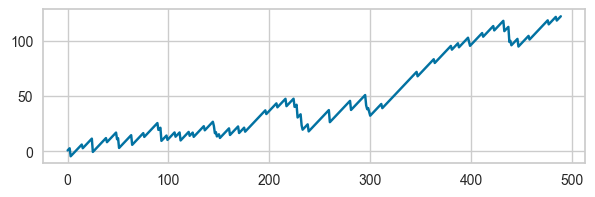

In [294]:
df_treino = info_modelo(tuned, real_treino, filtro = 4)

PL: 105.28 | ROI: 22.12% | Prec.: 0.90
Odd média: 8.87 (0.11 WR)
Média Gain: 0.96 | Média Loss: -6.41
EM: 0.23
476 entradas em 4000 jogos (11.90%)


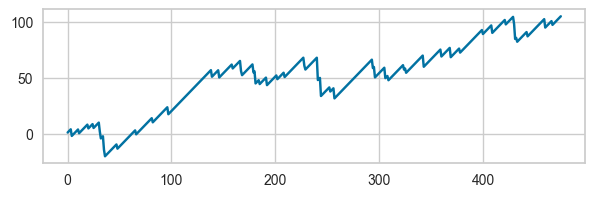

In [295]:
df_teste = info_modelo(tuned, real_teste, filtro = 4)

PL: 161.27 | ROI: 25.89% | Prec.: 0.90
Odd média: 8.86 (0.11 WR)
Média Gain: 0.97 | Média Loss: -5.91
EM: 0.28
623 entradas em 5665 jogos (11.00%)


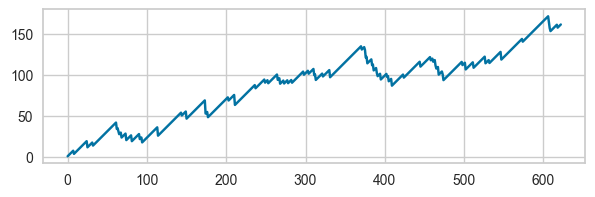

In [322]:
df_val = info_modelo(tuned, val, filtro = 4)

PL: 377.44 | ROI: 24.86% | Prec.: 0.90
Odd média: 9.11 (0.11 WR)
Média Gain: 0.97 | Média Loss: -6.19
EM: 0.25
1518 entradas em 13665 jogos (11.11%)


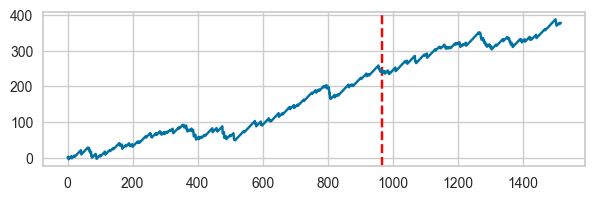

In [323]:
plt.axvline(x=len(df_treino) + len(df_teste), color='red', linestyle='--')
df_completo = info_modelo(tuned, df, filtro = 4)

# Validação 2

In [36]:
import sys
sys.path.append('../../../scripts/')
from PreparaDataset import *

ops = pd.read_csv('../../../data/Entire_Season.csv')
ops = ops[ops['Date'] > '2022-10-21']
ops = prepara_df(ops)
ops = prepara_dataset(ops)

ops = ops[ops['Date'] > '2023-09-10']

ops.dropna(inplace=True)
ops.sort_values('Date')
ops.reset_index(drop=True, inplace=True)

PL: 20.27 | ROI: 96.50% | Prec.: 1.00
Odd média: 8.75 (0.11 WR)
Média Gain: 0.97 | Média Loss: nan
EM: nan
21 entradas em 254 jogos (8.27%)


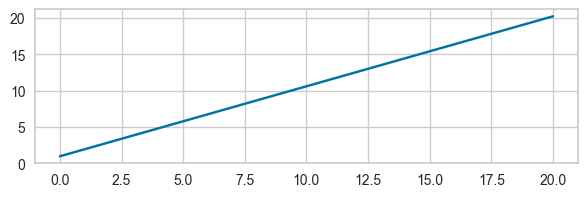

In [320]:
df_val2 = info_modelo(tuned, ops, filtro = 4)

# Script qcut

In [232]:
df_cut = df_treino.copy()
df_cut2 = df_teste.copy()

In [240]:
for var in features:
    try:
        labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 10, labels = labels)
        df_cut2[nome]  = pd.qcut(df_cut2[var], q = 10, labels = labels)

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        
        pivot_table2 = pd.pivot_table(df_cut2,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        
        list_pos_treino = []
        list_pos_teste = []

        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]
        pivot_table2['ratio'] = pivot_table2[('sum', target)] / pivot_table2[('count', target)]

        aux_treino = pivot_table[pivot_table['ratio'] > 0]
        aux_teste = pivot_table2[pivot_table2['ratio'] > 0]

        list_pos_treino = aux_treino.index.tolist()
        list_pos_teste = aux_teste.index.tolist()
        lista_cats = [valor for valor in list_pos_treino if valor in list_pos_teste]

        aux_treino = aux_treino[aux_treino.index.isin(lista_cats)]
        aux_teste = aux_teste[aux_teste.index.isin(lista_cats)]


        print(var)
        print(aux_treino)
        print()
        print(aux_teste)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

FT_Odds_H
                            sum             count     ratio
              PL_BF_Predictions PL_BF_Predictions          
Cat_FT_Odds_H                                              
1                        72.065               169  0.426420
2                        74.090               163  0.454540
3                        37.120               163  0.227730
4                        12.350               178  0.069382
6                        11.415               164  0.069604
9                        24.600               164  0.150000

                            sum             count     ratio
              PL_BF_Predictions PL_BF_Predictions          
Cat_FT_Odds_H                                              
1                        44.825               164  0.273323
2                         2.630               163  0.016135
3                        30.660               163  0.188098
4                        47.750               162  0.294753
6                        30.6

In [ ]:
_df = _df[((_df['Custo_Retorno_A'] >= -12.72) & (_df['Custo_Retorno_A'] < -8.72)) | ((_df['Custo_Retorno_A'] >= 5.4) & (_df['Custo_Retorno_A'] < 30))]

In [258]:
display(df_cut2.groupby('Cat_Custo_Retorno_A')['Custo_Retorno_A'].describe())

,count,mean,std,min,25%,50%,75%,max
Cat_Custo_Retorno_A,,,,,,,,
1,163.0,-195.609299,593.961365,-6140.000000,-124.736263,-77.551018,-53.968149,-43.239437
2,163.0,-29.774809,6.809639,-42.743904,-35.760368,-28.461538,-23.311404,-20.851065
3,163.0,-16.153528,2.292632,-20.845921,-17.557412,-15.805785,-14.321159,-12.732920
4,163.0,-10.561691,1.192013,-12.719836,-11.422216,-10.408432,-9.547163,-8.722045
5,163.0,-7.280435,0.751000,-8.713376,-7.972339,-7.259475,-6.605785,-6.023316
6,163.0,-4.440609,0.982447,-6.020000,-5.280751,-4.493671,-3.626658,-2.739130
7,163.0,0.775716,2.826087,-2.737307,-2.122227,1.588595,3.265508,5.350172
8,163.0,9.189587,2.544595,5.396825,6.869362,9.016736,11.477326,13.636364
9,163.0,20.419502,4.869742,13.750000,16.213983,19.605263,23.667017,30.476191


# Script variáveis

In [ ]:
colunas = ['P_Diff', 'Porc_Home_Win', 'Porc_Away_Win', 'Porc_Over05HT_Home', 'Porc_Over05HT_Away', 'Porc_Over15FT_Home',
 'Porc_Over15FT_Away', 'Porc_Over25FT_Home', 'Porc_Over25FT_Away', 'Porc_BTTS_Home', 'Porc_BTTS_Away', 'MediaOddsHome',
 'MediaOddsAway', 'DesvPadOddsHome', 'DesvPadOddsAway', 'MediaPontosHome', 'MediaPontosAway',
 'Avg_CG_H', 'DP_CG_H', 'CV_CG_H', 'Avg_Pontos_H', 'DP_Pontos_H', 'CV_Pontos_H', 'CG_H_Last_Game', 'Media_Odds_Geral_H',
 'DP_Odds_Geral_H', 'CV_Odds_Geral_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'Avg_Pontos_A', 'DP_Pontos_A', 'CV_Pontos_A',
 'CG_A_Last_Game', 'Media_Odds_Geral_A', 'DP_Odds_Geral_A', 'CV_Odds_Geral_A', 'MediaCustoGolHome', 'MediaCustoGolAway', 
 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H', 'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_MO', 'CV_MO_Over_Mean', 
 'DesvPadPontosHome', 'DesvPadPontosAway', 'Avg_Retornos_BH_Time_5', 'Avg_Retornos_BH_Liga', 'Dist_Retornos_BH', 
 'Retornos_BH_Acu', 'Retornos_BH_Acu_5', 'Ratio_Retornos_5_BH', 'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH', 
 'Avg_Retornos_BA_Time_5', 'Avg_Retornos_BA_Liga', 'Dist_Retornos_BA', 'Retornos_BA_Acu', 'Retornos_BA_Acu_5', 'Ratio_Retornos_5_BA',
 'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA', 'Avg_Retornos_Over_Time_5', 'Avg_Retornos_Over_Liga', 'Dist_Retornos_Over', 
 'Retornos_Over_Acu', 'Retornos_Over_Acu_5', 'Ratio_Retornos_5_Over', 'Avg_Porc_Over_Bookie', 'Avg_Porc_Over_Real', 'Dist_Porc_Over',
 'Avg_Retornos_D_Liga', 'Custo_Retorno_D']

In [ ]:
import random

def pegar_elementos_aleatorios(lista):
    # Gerar um número aleatório entre 2 e 7
    num_elementos = random.randint(8, 20)

    # Garantir que o número de elementos não ultrapasse o tamanho da lista
    num_elementos = min(num_elementos, len(lista))

    # Selecionar elementos aleatórios da lista
    elementos_aleatorios = random.sample(lista, num_elementos)

    return elementos_aleatorios

In [ ]:
melhor_PL = -10000

for i in range(50):
    features = pegar_elementos_aleatorios(colunas)
    features.append('FT_Odds_D')
    # features.extend(['FT_Odds_H', 'FT_Odds_D', 'FT_Odds_A', 'Odds_O25', 'BTTS_Yes'])

    cls = setup(data = treino,
            ignore_features = [x for x in treino.columns.to_list() if x not in features and x != 'Lay_Draw'],
            target = 'Lay_Draw',
            train_size = 0.5,
            normalize = True,
            normalize_method = 'zscore',
            session_id = 2023,
            remove_outliers = True,
            verbose = False
            )
    
    model = create_model('nb', verbose = False, fold = 5)
    tab = pull()
    prec_model = (tab.loc['Mean', 'Prec.'])
    previsoes = predict_model(model, verbose = False)
    stake = 1
    
    total = previsoes.shape[0]

    previsoes = previsoes[(previsoes['prediction_label'] == 1)]

    previsoes.loc[(previsoes['Lay_Draw'] == 0), 'PL_BF_Predictions'] = - (previsoes['FT_Odds_D'] + 0.05 - 1) * stake
    previsoes.loc[(previsoes['Lay_Draw'] == 1), 'PL_BF_Predictions'] = stake * 0.965

    plb = previsoes['PL_BF_Predictions'].sum()
    entradas = previsoes[previsoes['prediction_label'] == 1].shape[0]
    wr = round((previsoes[previsoes['Lay_Draw'] == 1].shape[0] / entradas), 2)
    oddback = previsoes[previsoes['prediction_label'] == 1]['FT_Odds_D'].mean()
    med_gain = previsoes[previsoes['Lay_Draw'] == 1]['PL_BF_Predictions'].mean()
    med_loss = previsoes[previsoes['Lay_Draw'] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    
    print(f'Rodada {i+1}')
    if plb > melhor_PL:
        melhor_PL = plb
        print(f'**Novo melhor**')
        print(f'Precision: {prec_model:.4f}')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print(f'features = {features}\n')
    print()

# Segundo filtro

In [ ]:
fits = ['CV_MO', 'MediaCustoGolAway', 'P_Diff', 'FT_Odds_D', 'DP_Odds_Geral_A', 'FT_Odds_A', 'Avg_Retornos_D_Liga', 'Avg_CG_A', 'DP_Pontos_A', 'CG_H_Last_Game', 'CV_Odds_Geral_A', 'Last_CG_H', 'FT_Odds_H', 'Media_Odds_Geral_A', 'Last_CG_A', 'DP_Pontos_H']

In [ ]:
cls = setup(data = treino,
        ignore_features = [x for x in treino.columns.to_list() if x not in fits and x != 'Lay_Draw'],
        target = 'Lay_Draw',
        train_size = 0.5,
        normalize = True,
        normalize_method = 'zscore',
        session_id = 2023,
        remove_outliers = True,
        verbose = False
        )

model = create_model('nb', verbose = False, fold = 5)
tab = pull()
prec_model = (tab.loc['Mean', 'Prec.'])
previsoes = predict_model(model, verbose = False)
stake = 1

previsoes = previsoes.merge(treino['FT_Odds_D'], left_index=True, right_index=True, how='left')
if 'FT_Odds_D_x' in previsoes.columns.tolist():
    previsoes.rename(columns={'FT_Odds_D_x': 'FT_Odds_D'}, inplace=True)
    previsoes.drop(columns='FT_Odds_D_y', inplace=True)

total = previsoes.shape[0]

previsoes = previsoes[(previsoes['prediction_label'] == 1)]

previsoes.loc[(previsoes['Lay_Draw'] == 0), 'PL_BF_Predictions'] = - (previsoes['FT_Odds_D'] + 0.05 - 1) * stake
previsoes.loc[(previsoes['Lay_Draw'] == 1), 'PL_BF_Predictions'] = stake * 0.965

plb = previsoes['PL_BF_Predictions'].sum()
entradas = previsoes[previsoes['prediction_label'] == 1].shape[0]
wr = round((previsoes[previsoes['Lay_Draw'] == 1].shape[0] / entradas), 2)
oddback = previsoes[previsoes['prediction_label'] == 1]['FT_Odds_D'].mean()
med_gain = previsoes[previsoes['Lay_Draw'] == 1]['PL_BF_Predictions'].mean()
med_loss = previsoes[previsoes['Lay_Draw'] == 0]['PL_BF_Predictions'].mean()
roi = plb / entradas
porc_ent = entradas / total
ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
print('---------------------- BASE ----------------------')
print(f'Precision: {prec_model:.4f}')
print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
print(f'fits = {fits}\n')
print('--------------------------------------------------')
melhor_PL = plb


for i in range(len(fits)):
    feat = fits[i]
    fits.pop(i)
    print(f'Removido: {feat}')

    cls = setup(data = treino,
            ignore_features = [x for x in treino.columns.to_list() if x not in fits and x != 'Lay_Draw'],
            target = 'Lay_Draw',
            train_size = 0.5,
            normalize = True,
            normalize_method = 'zscore',
            session_id = 2023,
            remove_outliers = True,
            verbose = False
            )
    
    model = create_model('nb', verbose = False, fold = 5)
    tab = pull()
    prec_model = (tab.loc['Mean', 'Prec.'])
    previsoes = predict_model(model, verbose = False)
    stake = 1

    previsoes = previsoes.merge(treino['FT_Odds_D'], left_index=True, right_index=True, how='left')
    if 'FT_Odds_D_x' in previsoes.columns.tolist():
        previsoes.rename(columns={'FT_Odds_D_x': 'FT_Odds_D'}, inplace=True)
        previsoes.drop(columns='FT_Odds_D_y', inplace=True)
    
    total = previsoes.shape[0]

    previsoes = previsoes[(previsoes['prediction_label'] == 1)]

    previsoes.loc[(previsoes['Lay_Draw'] == 0), 'PL_BF_Predictions'] = - (previsoes['FT_Odds_D'] + 0.05 - 1) * stake
    previsoes.loc[(previsoes['Lay_Draw'] == 1), 'PL_BF_Predictions'] = stake * 0.965

    plb = previsoes['PL_BF_Predictions'].sum()
    entradas = previsoes[previsoes['prediction_label'] == 1].shape[0]
    wr = round((previsoes[previsoes['Lay_Draw'] == 1].shape[0] / entradas), 2)
    oddback = previsoes[previsoes['prediction_label'] == 1]['FT_Odds_D'].mean()
    med_gain = previsoes[previsoes['Lay_Draw'] == 1]['PL_BF_Predictions'].mean()
    med_loss = previsoes[previsoes['Lay_Draw'] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    
    if plb >= melhor_PL:
        print('*** NOVO MELHOR ***')
        melhor_PL = plb
    print(f'Precision: {prec_model:.4f}')
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
    print(f'fits = {fits}\n')
    fits.insert(i, feat)
    print()

# Cross validation

In [330]:
results = []
seeds = random.sample(range(0, 9999), 10)

for i in range(len(seeds)):

        cls = setup(data = treino,
                ignore_features = [x for x in treino.columns.to_list() if x not in features and x != 'Lay_Zebra'],
                target = 'Lay_Zebra',
                train_size = 0.5,
                normalize = True,
                normalize_method = 'zscore',
                session_id = seeds[i],
                remove_outliers = True,
                verbose = False
                )

        model = create_model('lr', verbose = False, cross_validation=False, C=5.215267284105792, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2023, solver='lbfgs', tol=0.0001)
        
        previsoes = predict_model(model, verbose = False)
        previsoes = previsoes.merge(df['Odds'], left_index=True, right_index=True, how='left')
        if 'Odds_x' in previsoes.columns.tolist():
                previsoes.rename(columns={'Odds_x': 'Odds'}, inplace=True)
                previsoes.drop(columns='Odds_y', inplace=True)

        stake = 1

        total = previsoes.shape[0]

        previsoes = previsoes[(previsoes['prediction_label'] == 1)]

        previsoes.loc[(previsoes['Lay_Zebra'] == 0), 'PL_BF_Predictions'] = - (previsoes['Odds'] + 0.05 - 1) * stake
        previsoes.loc[(previsoes['Lay_Zebra'] == 1), 'PL_BF_Predictions'] = stake * 0.965

        ############ Filtro ############
        previsoes = filtra_resultados(previsoes, filtro = 4)
    
        plb = previsoes['PL_BF_Predictions'].sum()
        entradas = previsoes[previsoes['prediction_label'] == 1].shape[0]
        wr = round((previsoes[previsoes['Lay_Zebra'] == 1].shape[0] / entradas), 2)
        oddback = previsoes[previsoes['prediction_label'] == 1]['Odds'].mean()
        med_gain = previsoes[previsoes['Lay_Zebra'] == 1]['PL_BF_Predictions'].mean()
        med_loss = previsoes[previsoes['Lay_Zebra'] == 0]['PL_BF_Predictions'].mean()
        roi = plb / entradas
        porc_ent = entradas / total
        ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
        
        results.append(wr)

        print(f'Fold {i+1} (seed {seeds[i]})')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print()

print(f'Média: {np.mean(results):.2f} | DP: {np.std(results):.2f}')

Fold 1 (seed 9265)
PL: 125.06 | ROI: 25.95% | EM: 0.27 | Prec.: 0.90 | Entradas: 0.12

Fold 2 (seed 9822)
PL: 84.11 | ROI: 17.20% | EM: 0.20 | Prec.: 0.90 | Entradas: 0.12

Fold 3 (seed 3232)
PL: 119.80 | ROI: 25.49% | EM: 0.28 | Prec.: 0.90 | Entradas: 0.12

Fold 4 (seed 4447)
PL: 103.90 | ROI: 21.69% | EM: 0.21 | Prec.: 0.89 | Entradas: 0.12

Fold 5 (seed 4226)
PL: 67.95 | ROI: 13.64% | EM: 0.14 | Prec.: 0.88 | Entradas: 0.12

Fold 6 (seed 384)
PL: 53.35 | ROI: 11.07% | EM: 0.11 | Prec.: 0.88 | Entradas: 0.12

Fold 7 (seed 7199)
PL: 70.74 | ROI: 14.86% | EM: 0.17 | Prec.: 0.89 | Entradas: 0.12

Fold 8 (seed 7476)
PL: 116.37 | ROI: 24.19% | EM: 0.26 | Prec.: 0.90 | Entradas: 0.12

Fold 9 (seed 5758)
PL: 166.43 | ROI: 33.97% | EM: 0.31 | Prec.: 0.90 | Entradas: 0.12

Fold 10 (seed 1647)
PL: 124.36 | ROI: 25.70% | EM: 0.23 | Prec.: 0.89 | Entradas: 0.12

Média: 0.89 | DP: 0.01
